# Atividade vivencial - Aprendizado profundo

Neste notebook iremos utilizar a biblioteca [Keras](https://www.keras.io) para construir redes neurais do tipo Convolutional Neural Networks (CNNs). Revisitaremos a implementação da CNN do módulo 6, mas para outro dataset. Em particular, iremos criar uma CNN para classificar imagens do dataset CIFAR-100. As imagens deste dataset são classificadas em 100 classes. Para facilitar nosso trabalho, consideraremos um agrupamento destas classes em 20 super-classes.

Nosso objetivo aqui é entender melhor como uma CNN funciona. Ao final, você deverá realizar os exercícios propostos.

Para começar, precisamos importar algumas bibliotecas básicas: `numpy` para lidar com operações numéricas, `matplotlib` para criar gráficos e `keras` para criar redes neurais.

In [57]:
import keras
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Para utilizar o dataset em questão, basta executar o comando abaixo.  Este comando retorna duas tuplas, as quais representam os dados de treino (entrada e saída) e de teste (entrada e saída).

In [58]:
# carrega os conjuntos de treino e teste
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')

Podemos visualizar alguns exemplos (entrada e saída) do dataset utilizando o código abaixo.

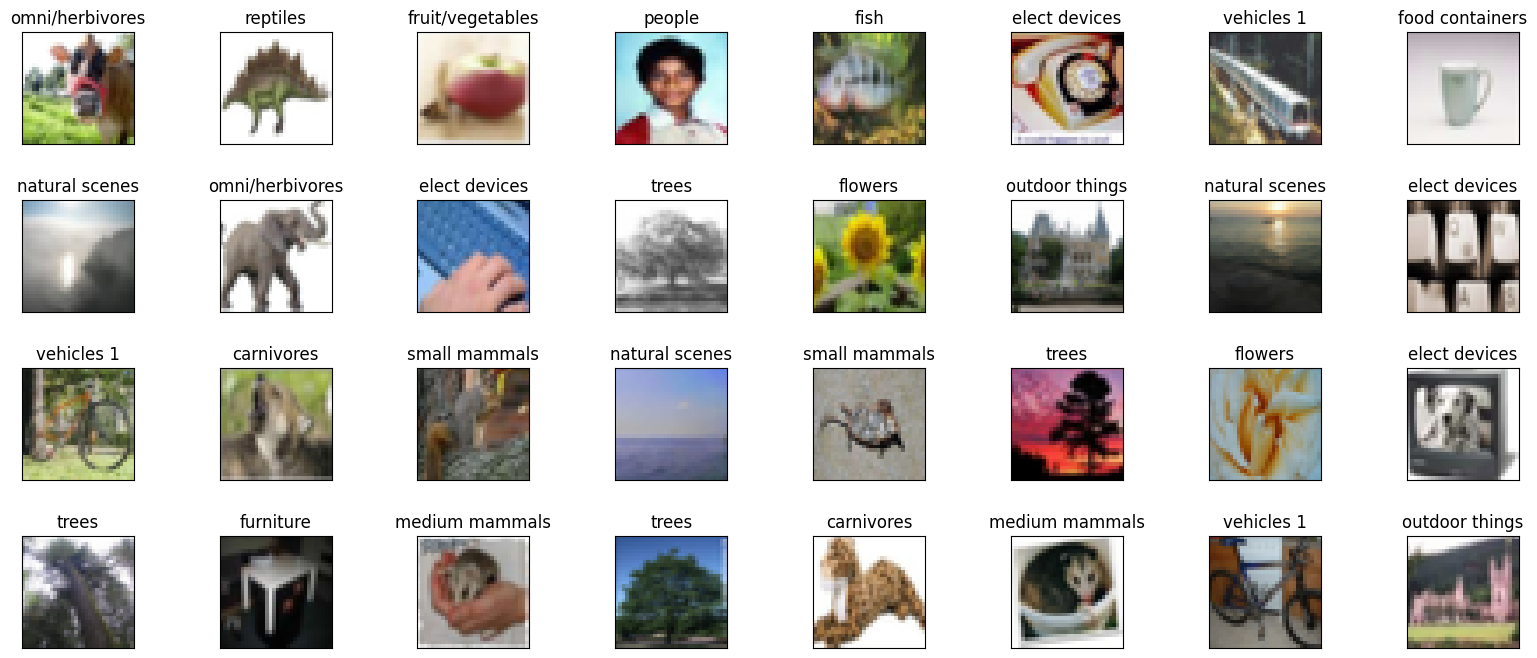

In [59]:
cifar100_labels = ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit/vegetables', 'elect devices', 'furniture', 'insects', 'carnivores', 'outdoor things', 'natural scenes', 'omni/herbivores', 'medium mammals', 'invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2']

fig = plt.figure(figsize=(20, 8))
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(cifar100_labels[y_train[i][0]]))

fig.subplots_adjust(hspace=0.5)

Após carregar os dados, devemos tratá-los para melhorar o treinamento. No nosso caso, vamos apenas normalizar as cores (atualmente no intervalo [0,255]) para o intervalo [0,1].

In [60]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Em seguida, podemos codificar as classes utilizando o one-hot encoding. Isto vai facilitar a tarefa de aprendizado.

In [61]:
# codificação one-hot das categorias
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Outro passo importante é separar uma parte do conjunto de treino para validação. O objetivo é reduzir o bias do conjunto de teste.

In [62]:
# divide os dados em treino, teste e validação
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

Após os tratamentos acima, podemos identificar o formato resultante dos nossos dados com os comandos abaixo.

In [63]:
# imprime o formato dos dados de entrada
print('formato dos dados de entrada:', x_train.shape)

# imprime o tamanho dos conjuntos
print(x_train.shape[0], 'amostras de treino')
print(x_valid.shape[0], 'amostras de validação')
print(x_test.shape[0], 'amostras de teste')

formato dos dados de entrada: (45000, 32, 32, 3)
45000 amostras de treino
5000 amostras de validação
10000 amostras de teste


Processados os dados, agora devemos criar a CNN. Como de costume, trabalharemos com um modelo sequencial.

In [64]:
model = Sequential()

Em seguida, podemos empilhar as camadas de convolução e agrupamento desejadas. Neste nosso caso, estamos trabalhando com 3 camadas convolucionais, cada qual com kernel de tamanho 2x2 e função de ativação ReLU. Após cada camada convolucional empilhamos uma camada de max pooling com kernel de tamanho 2x2.

In [65]:
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Lembre-se que as camadas convolucionais servem como um extrator de features, as quais serão utilizadas por um classificador MLP. Desta forma, agora precisamos converter a saída da parte convolucional para um vetor, que é o formato aceito por uma MLP. Isto pode ser feito com uma camada `Flatten`, como abaixo.

In [66]:
model.add(Flatten())

Finalmente, agora podemos adicionar as camadas densas de uma MLP para realizar a classificação. Note também que estamos utilizando Dropout para reduzir o overfitting.

In [67]:
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(20, activation='softmax'))

Nossa rede resultante é resumida abaixo.

In [68]:
model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_74 (Conv2D)                   │ (None, 32, 32, 16)          │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 16, 16, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_75 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 8, 8, 64)            │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 100)                 │         102,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 20)                  │           2,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,064 (449.47 KB)

 Trainable params: 115,064 (449.47 KB)

 Non-trainable params: 0 (0.00 B)

O próximo passo é compilar nosso modelo. Os parâmetros abaixo foram escolhidos por serem próprios para classificação.

In [69]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Agora podemos finalmente treinar nosso modelo. **Cuidado, este processo pode demorar bastante!**  Para facilitar o estudo, reduzimos o número de épocas para apenas 20. Tente aumentar o número de épocas para ver entender melhor o efeito deste parâmetro nos resultados.

Note que antes do treino, criamos um checkpoint. Um checkpoint permite que o modelo seja salvo em um arquivo. No nosso caso, apenas o melhor modelo será salvo. Desta forma, poderemos carregar nosso modelo posteriormente sem precisar treinar novamente a rede.

In [70]:
# cria um checkpoint para salvar os pesos do melhor modelo encontrado no trainamento
checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', verbose=1, save_best_only=True)

# treina o modelo
hist = model.fit(x_train, y_train, batch_size=32, epochs=20,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer],
          verbose=2, shuffle=True)

Epoch 1/20

Epoch 1: val_loss improved from inf to 2.36149, saving model to model.weights.best.keras
1407/1407 - 11s - 8ms/step - accuracy: 0.1962 - loss: 2.5885 - val_accuracy: 0.2680 - val_loss: 2.3615
Epoch 2/20

Epoch 2: val_loss improved from 2.36149 to 2.11075, saving model to model.weights.best.keras
1407/1407 - 4s - 3ms/step - accuracy: 0.3033 - loss: 2.2553 - val_accuracy: 0.3490 - val_loss: 2.1108
Epoch 3/20

Epoch 3: val_loss improved from 2.11075 to 1.99020, saving model to model.weights.best.keras
1407/1407 - 6s - 4ms/step - accuracy: 0.3478 - loss: 2.1153 - val_accuracy: 0.3822 - val_loss: 1.9902
Epoch 4/20

Epoch 4: val_loss did not improve from 1.99020
1407/1407 - 3s - 2ms/step - accuracy: 0.3788 - loss: 2.0178 - val_accuracy: 0.3846 - val_loss: 2.0472
Epoch 5/20

Epoch 5: val_loss improved from 1.99020 to 1.84799, saving model to model.weights.best.keras
1407/1407 - 6s - 4ms/step - accuracy: 0.3991 - loss: 1.9534 - val_accuracy: 0.4178 - val_loss: 1.8480
Epoch 6/20

Ep

Treinado o modelo, podemos analisar seu desempenho através dos gráficos abaixo.

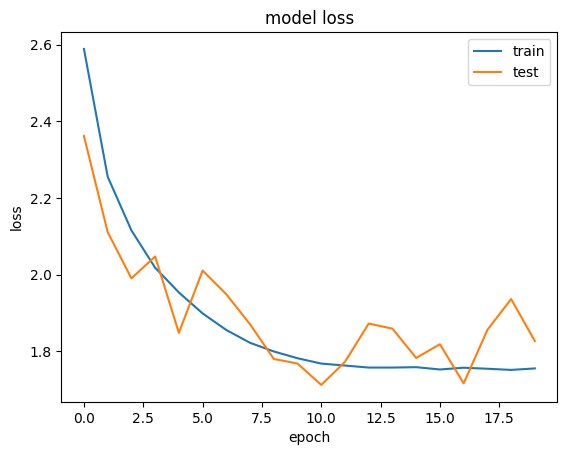

In [71]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

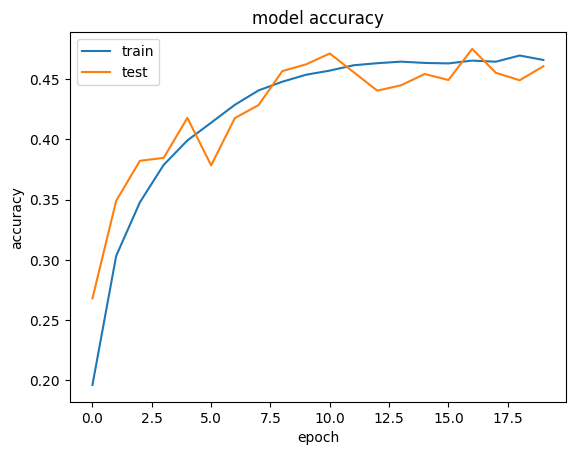

In [72]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Como pode ser observado, nossa rede CNN conseguiu obter resultados bem interessantes mesmo sem uma otimização dos hiper-parâmetros.

Após concluir o treino, podemos carregar o melhor modelo utilizando o comando abaixo.

In [73]:
# carrega os pesos do melhor modelo encontrado no treinamento
model.load_weights('model.weights.best.keras')

A acurácia pode ser medida como segue.

In [74]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.46860000491142273


Finalmente, podemos visualizar algumas predições do nosso modelo para entender melhor seu comportamento.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


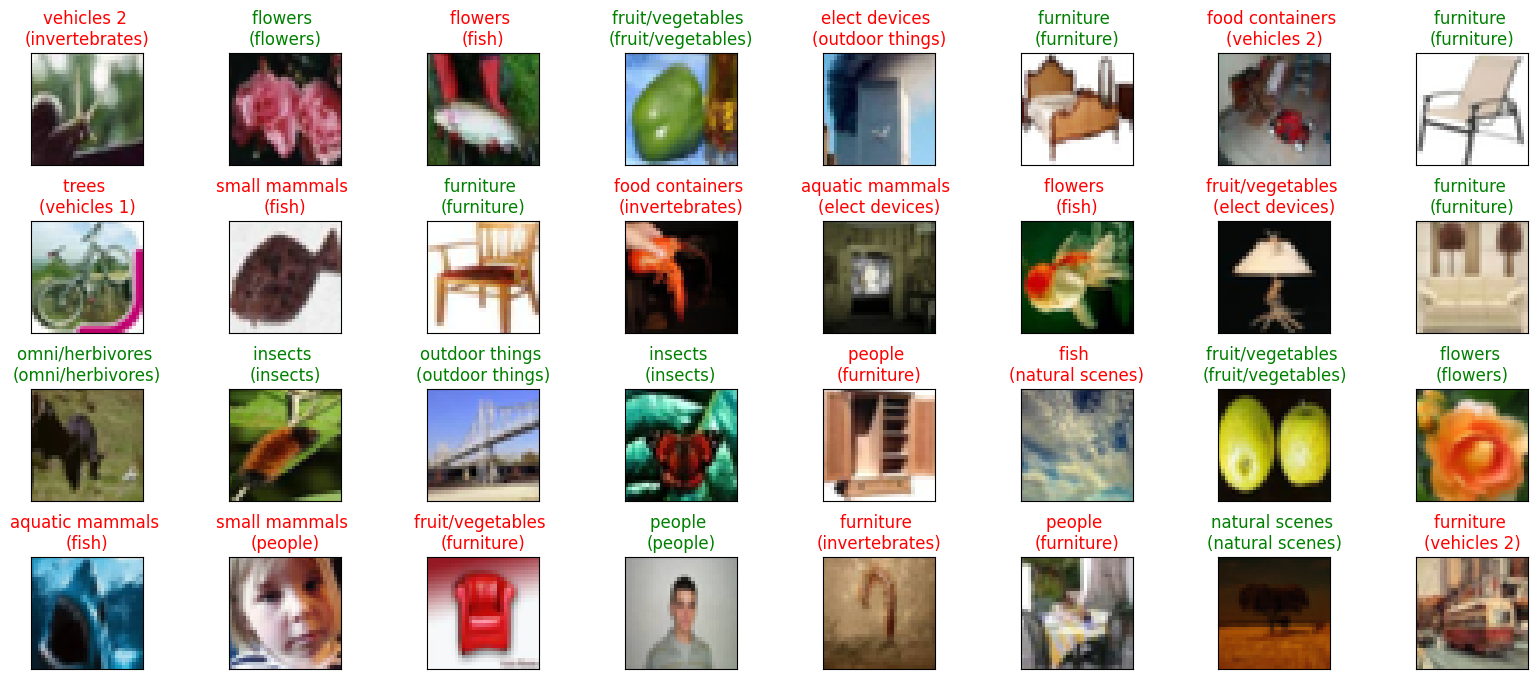

In [75]:
# obtém as predições
y_hat = model.predict(x_test)

# exibe alguns exemplos aleatórios do teste, bem como sua predição e o resultado esperado
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} \n({})".format(cifar100_labels[pred_idx], cifar100_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

fig.subplots_adjust(hspace=0.5)

## Exercícios

### Exercício 1

Teste diferentes combinações de hiper-parâmetros (e.g., quantidade de camadas, ordem das camadas, tamanho das camadas, loss function, otimizador, número de épocas, etc.) para a CNN criada acima. Em seguida, crie uma tabela relacionado as combinações de hiper-parâmetros testadas e os resultados obtidos. Ao final, indique a melhor combinação.

Camada 1 | Camada 2 | Camada 3 | Camada 4 | Camada 5 | Camada 6 | Camada 7 | Camada 8 | Camada 9 | Camada 10 | Otimizador | Episódios | Acurácia | Melhor?
---|---|---|---|---|---|---|---|---|---|---|---|---|---
Conv16 | MaxP | Conv32 | MaxP | Conv64 | MaxP | Flatten | Dense100 | Dropout0.4 | Dense20 | RMSprop | 20 | 0.4632 | &check;
- | - | - | - | - | - | - | - | - | - | - | - | - | &cross;
- | - | - | - | - | - | - | - | - | - | - | - | - | &cross;
- | - | - | - | - | - | - | - | - | - | - | - | - | &cross;
- | - | - | - | - | - | - | - | - | - | - | - | - | &cross;
- | - | - | - | - | - | - | - | - | - | - | - | - | &cross;


In [90]:
# teste melhor modelo

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0
y_train, y_val, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_val), tf.keras.utils.to_categorical(y_test)

param_grid = [
    {'conv_filters': [16, 32, 64], 'dense_units': [100, 200, 300],
     'dropout_rate': [0.2, 0.4, 0.5], 'optimizer': ['RMSprop', 'Adam', 'SGD'],
     'epochs': [10, 20]}
]

results = []

for params in param_grid:
    for conv_filter in params['conv_filters']:
        for dense_unit in params['dense_units']:
            for dropout_rate in params['dropout_rate']:
                for optimizer in params['optimizer']:
                    for epochs in params['epochs']:
                        print(f"Treinando: Conv {conv_filter}, Dense {dense_unit}, Dropout {dropout_rate}, "
                              f"Optimizer {optimizer}, Epochs {epochs}")

                        model = Sequential([
                            Input(shape=x_train.shape[1:]),
                            Conv2D(conv_filter, (3, 3), activation='relu'),
                            MaxPooling2D((2, 2)),
                            Conv2D(conv_filter * 2, (3, 3), activation='relu'),
                            MaxPooling2D((2, 2)),
                            Flatten(),
                            Dense(dense_unit, activation='relu'),
                            Dropout(dropout_rate),
                            Dense(10, activation='softmax')
                        ])

                        if optimizer == 'RMSprop':
                            opt = RMSprop()
                        elif optimizer == 'Adam':
                            opt = Adam()
                        elif optimizer == 'SGD':
                            opt = SGD()

                        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

                        history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), verbose=0)

                        val_acc = history.history['val_accuracy'][-1]
                        print(f"Finalizado: Validation Accuracy: {val_acc:.4f}")

                        results.append({
                            'Conv Filters': conv_filter,
                            'Dense Units': dense_unit,
                            'Dropout Rate': dropout_rate,
                            'Optimizer': optimizer,
                            'Epochs': epochs,
                            'Validation Accuracy': val_acc
                        })

results_df = pd.DataFrame(results)

results_df['Best'] = results_df['Validation Accuracy'] == results_df['Validation Accuracy'].max()

file_path = '/mnt/data/resultados_hiperparametros.csv'
results_df.to_csv(file_path, index=False)

file_path


Treinando: Conv 16, Dense 100, Dropout 0.2, Optimizer RMSprop, Epochs 10
Finalizado: Validation Accuracy: 0.6783
Treinando: Conv 16, Dense 100, Dropout 0.2, Optimizer RMSprop, Epochs 20
Finalizado: Validation Accuracy: 0.6652
Treinando: Conv 16, Dense 100, Dropout 0.2, Optimizer Adam, Epochs 10
Finalizado: Validation Accuracy: 0.6711
Treinando: Conv 16, Dense 100, Dropout 0.2, Optimizer Adam, Epochs 20
Finalizado: Validation Accuracy: 0.6702
Treinando: Conv 16, Dense 100, Dropout 0.2, Optimizer SGD, Epochs 10
Finalizado: Validation Accuracy: 0.5684
Treinando: Conv 16, Dense 100, Dropout 0.2, Optimizer SGD, Epochs 20
Finalizado: Validation Accuracy: 0.6222
Treinando: Conv 16, Dense 100, Dropout 0.4, Optimizer RMSprop, Epochs 10
Finalizado: Validation Accuracy: 0.6453
Treinando: Conv 16, Dense 100, Dropout 0.4, Optimizer RMSprop, Epochs 20
Finalizado: Validation Accuracy: 0.6610
Treinando: Conv 16, Dense 100, Dropout 0.4, Optimizer Adam, Epochs 10
Finalizado: Validation Accuracy: 0.6782


KeyboardInterrupt: 

In [102]:
# Exercício 1

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import os

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0
y_train, y_val, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_val), tf.keras.utils.to_categorical(y_test)

best_model_path = 'model.weights.best.keras'

checkpoint = ModelCheckpoint(filepath=best_model_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

model = Sequential([
    Input(shape=x_train.shape[1:]),  # Definindo o formato de entrada
    Conv2D(16, (3, 3), activation='relu'),  # Primeira camada convolucional
    MaxPooling2D((2, 2)),  # Camada de pooling
    Conv2D(32, (3, 3), activation='relu'),  # Segunda camada convolucional
    MaxPooling2D((2, 2)),  # Segunda camada de pooling
    Flatten(),  # Camada de flatten para entrada na densa
    Dense(200, activation='relu'),  # Camada densa com 200 neurônios
    Dropout(0.4),  # Dropout de 40% para regularização
    Dense(10, activation='softmax')  # Saída com 10 classes (CIFAR-10)
])

optimizer = Adam()

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=10,  # Melhor resultado foi com 10 épocas
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

if os.path.exists(best_model_path):
    print("Pesos do melhor modelo salvos com sucesso!")
else:
    print("Erro ao salvar os pesos do melhor modelo.")

model.load_weights(best_model_path)

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Melhor modelo carregado - Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
1235/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3197 - loss: 1.8398
Epoch 1: val_accuracy improved from -inf to 0.51910, saving model to model.weights.best.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3208 - loss: 1.8371 - val_accuracy: 0.5191 - val_loss: 1.3465
Epoch 2/10
1231/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5159 - loss: 1.3534
Epoch 2: val_accuracy improved from 0.51910 to 0.57030, saving model to model.weights.best.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5161 - loss: 1.3529 - val_accuracy: 0.5703 - val_loss: 1.2027
Epoch 3/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5683 - loss: 1.2024
Epoch 3: val_accuracy improved from 0.57030 to 0.61270, saving model to model.weights.best.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5683 - loss: 1.2024 - val_accuracy: 0.6127 - val_loss: 1.0908
Epoch 4/10
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6080 - loss: 1.1029
Epo